In [5]:
import json
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.rcParams["figure.figsize"] = (20, 10)

## Training Environments
Different configurations of agents and thus differents dynamic of price and volume to train the rl agent


## Orderbook

In [6]:
result_dir = Path("simulation_result/multi/ppo_rl_500")
train_dirs = os.listdir(result_dir / 'train')
validate_dirs = os.listdir(result_dir / 'validate')

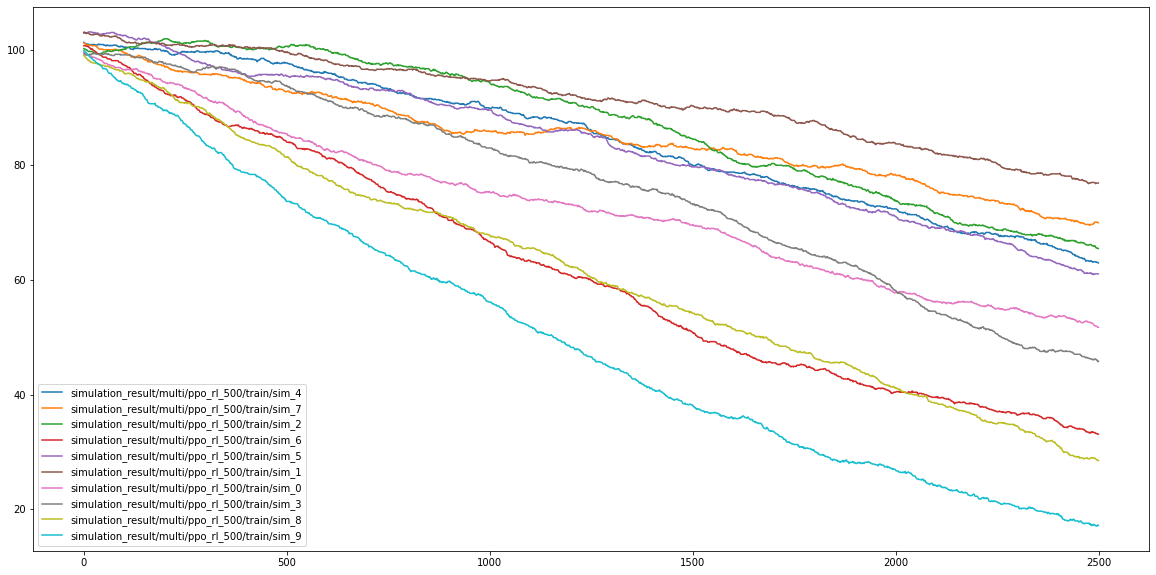

In [62]:
# train
for train_dir in train_dirs:
    train_dir = result_dir / 'train' / train_dir
    security_path = train_dir / "TSMC.json"
    agent_path = train_dir / "agent.json"
    # tsmc = pd.read_json(security_path)
    # plt.plot(tsmc['close'], color = 'r')
    market = json.loads(security_path.read_text())
    plt.plot(market['price'][100:], label = train_dir)
    plt.legend()

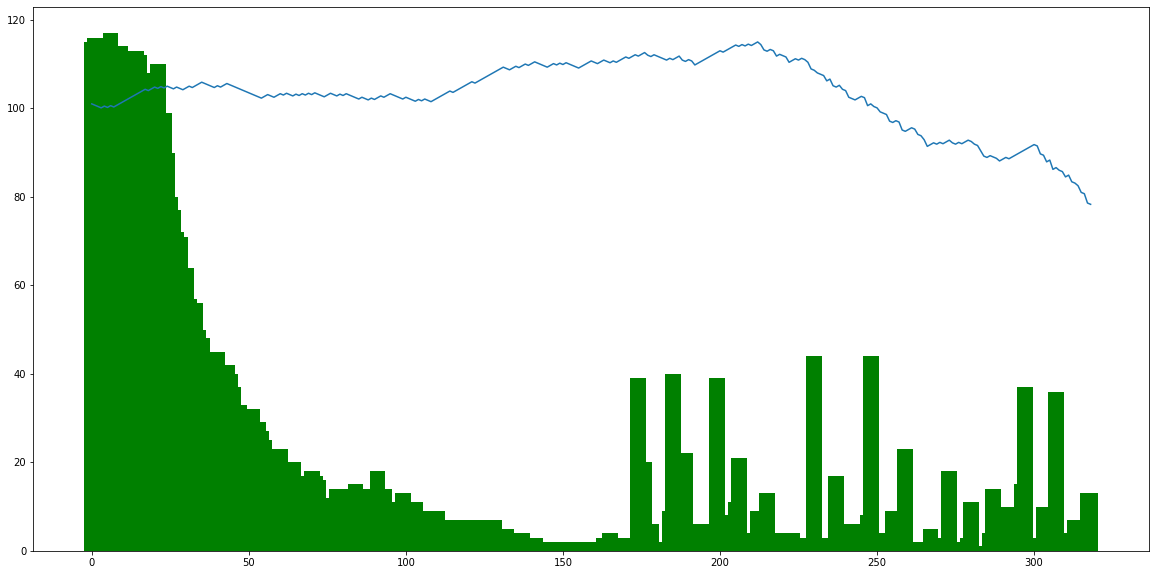

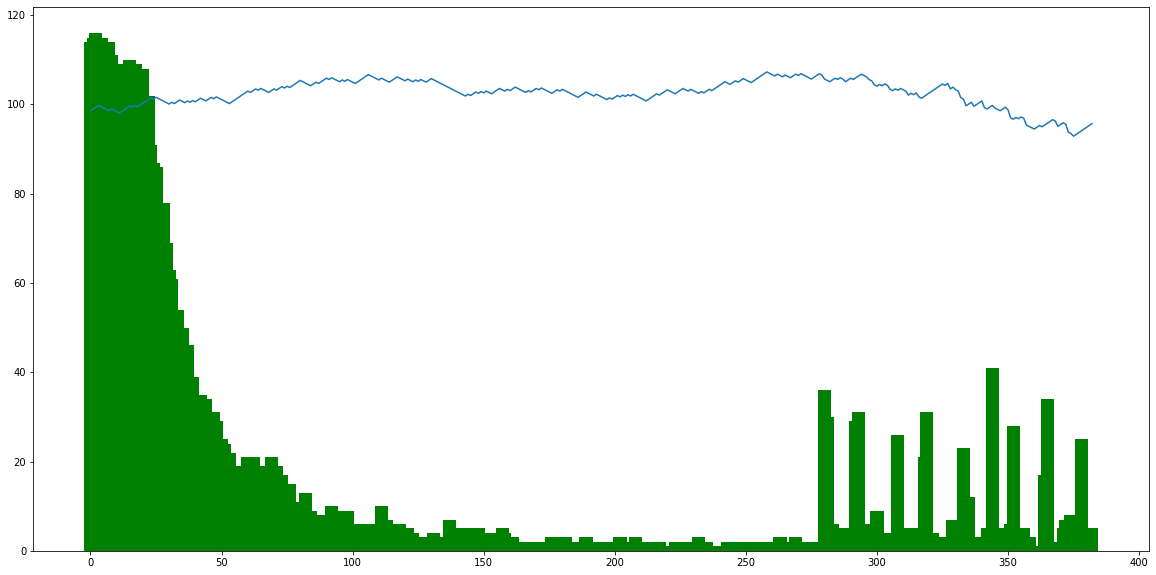

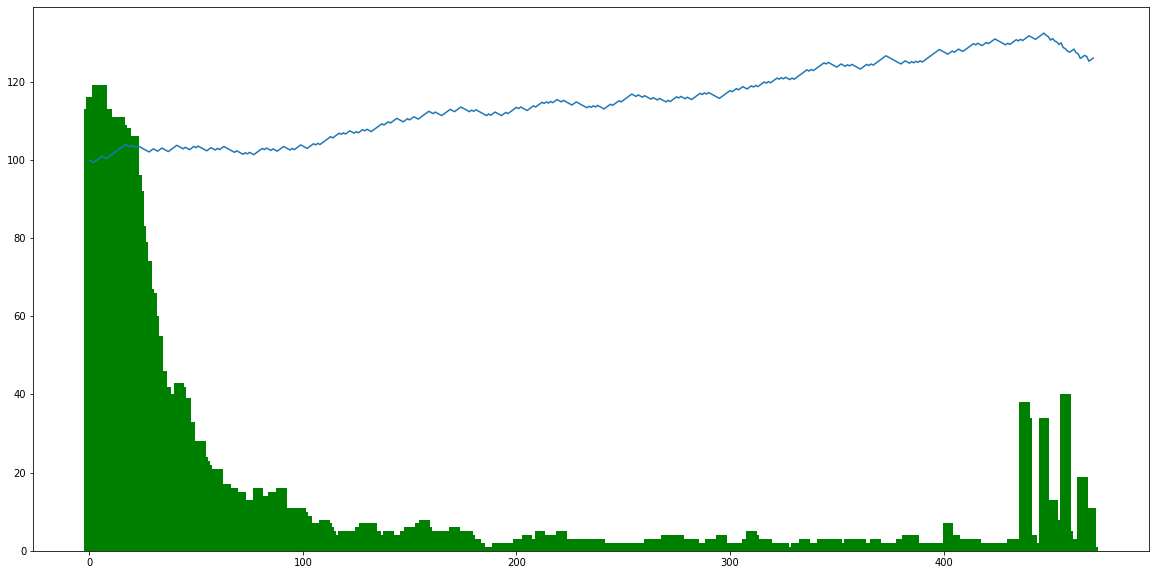

In [67]:
# validate
for validate_dir in validate_dirs:
    validate_dir = result_dir / 'validate' / validate_dir
    security_path = validate_dir / "TSMC.json"
    agent_path = validate_dir / "agent.json"
    market = json.loads(security_path.read_text())
    plt.plot(market['price'][100:])
    plt.bar([i for i in range(len(market['volume'][100:]))], market['volume'][100:], width = 5, color = 'g')
    plt.show()


In [8]:
import time
from IPython import display
from IPython.display import clear_output

for bids, asks in zip(market['bid_five_price'], market['ask_five_price']):
    length = min(len(bids), len(asks))
    bid_prices = list(bids.keys())
    bid_volumes = list(bids.values())
    ask_prices = list(asks.keys())
    ask_volumes = list(asks.values())
    clear_output(wait=True)
    display.display(pd.DataFrame([bid_prices, bid_volumes, ask_prices, ask_volumes], index=['bid_price', 'bid_volumn', 'ask_price', 'ask_volumn']).T)
    time.sleep(0.2)

,bid_price,bid_volumn,ask_price,ask_volumn
0,101.1,86,100.3,97
1,101.0,129,100.4,133
2,100.9,139,100.5,126
3,100.8,115,100.6,66
4,100.7,71,100.7,114


## Agent

In [56]:
agent = pd.read_json(agent_path)
group_names = agent.columns
num_of_timesteps = len(agent[group_names[0]]['cash'])
print(group_names)
print(agent[agent.columns[0]].index)

Index(['rl_1000'], dtype='object')
Index(['TSMC', 'average_cost', 'cash', 'group_asks_volume',
       'group_bids_volume', 'initial_cash_by_agent',
       'initial_security_by_agent', 'initial_wealth_by_agent',
       'returns_by_agent', 'timestep_ask', 'timestep_bid', 'wealth'],
      dtype='object')


### Holdings

#### Initial state

In [57]:
num_agent = 0
total_cash, total_TSMC = 0, 0
zi_cash, zi_TSMC = 0, 0
for group_name in group_names:
    if 'dh' in group_name:
        continue
    elif 'zi' in group_name:
        zi_cash += sum(agent[group_name]['initial_cash_by_agent'])
        zi_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
    else:
        total_cash += sum(agent[group_name]['initial_cash_by_agent'])
        total_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
        num_agent += len(agent[group_name]['initial_cash_by_agent'])

print(f"Number of agents: {num_agent}")
print(f"Total TSMC: {total_TSMC} Total cash: {total_cash}")
print(f"Average TSMC: {total_TSMC // num_agent} Average cash: {total_cash // num_agent}")
print(f"ZI TSMC: {zi_TSMC} ZI cash: {zi_cash}")
if 'dh_1' in group_names:
    print(f"Dahoo cash: {agent['dh_1']['initial_cash_by_agent'][0]}")

Number of agents: 1000
Total TSMC: 61311 Total cash: 618009590
Average TSMC: 61 Average cash: 618009
ZI TSMC: 0 ZI cash: 0


#### Wealth

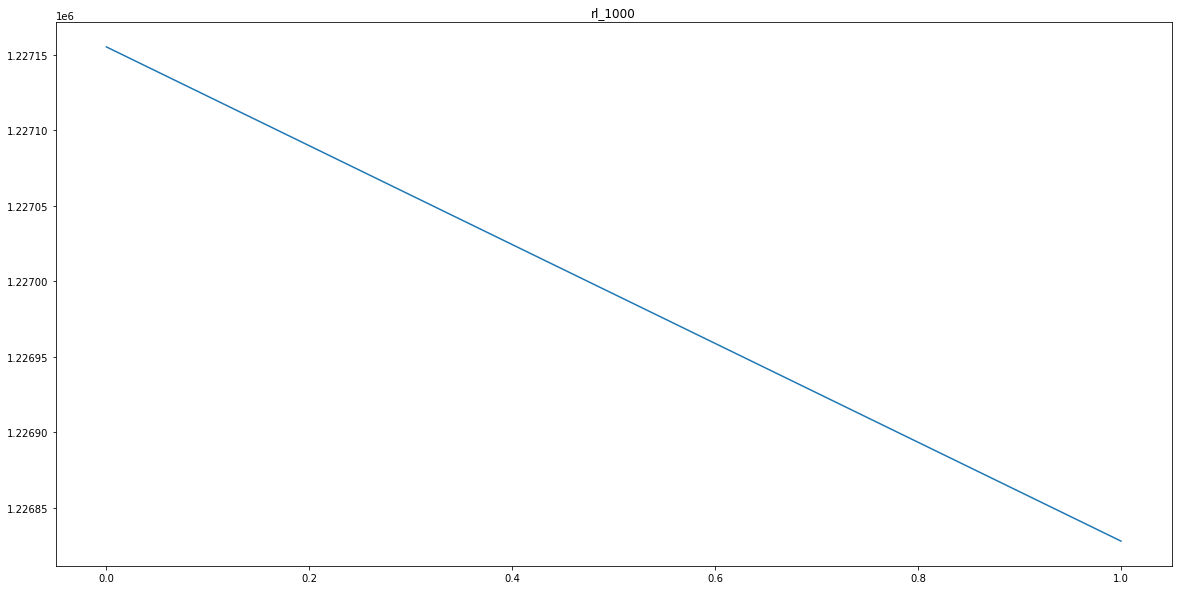

In [13]:
# for agent_type in agent.columns:
for group_name in agent.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(agent[group_name]['wealth'])
    plt.title(group_name)
    plt.show()

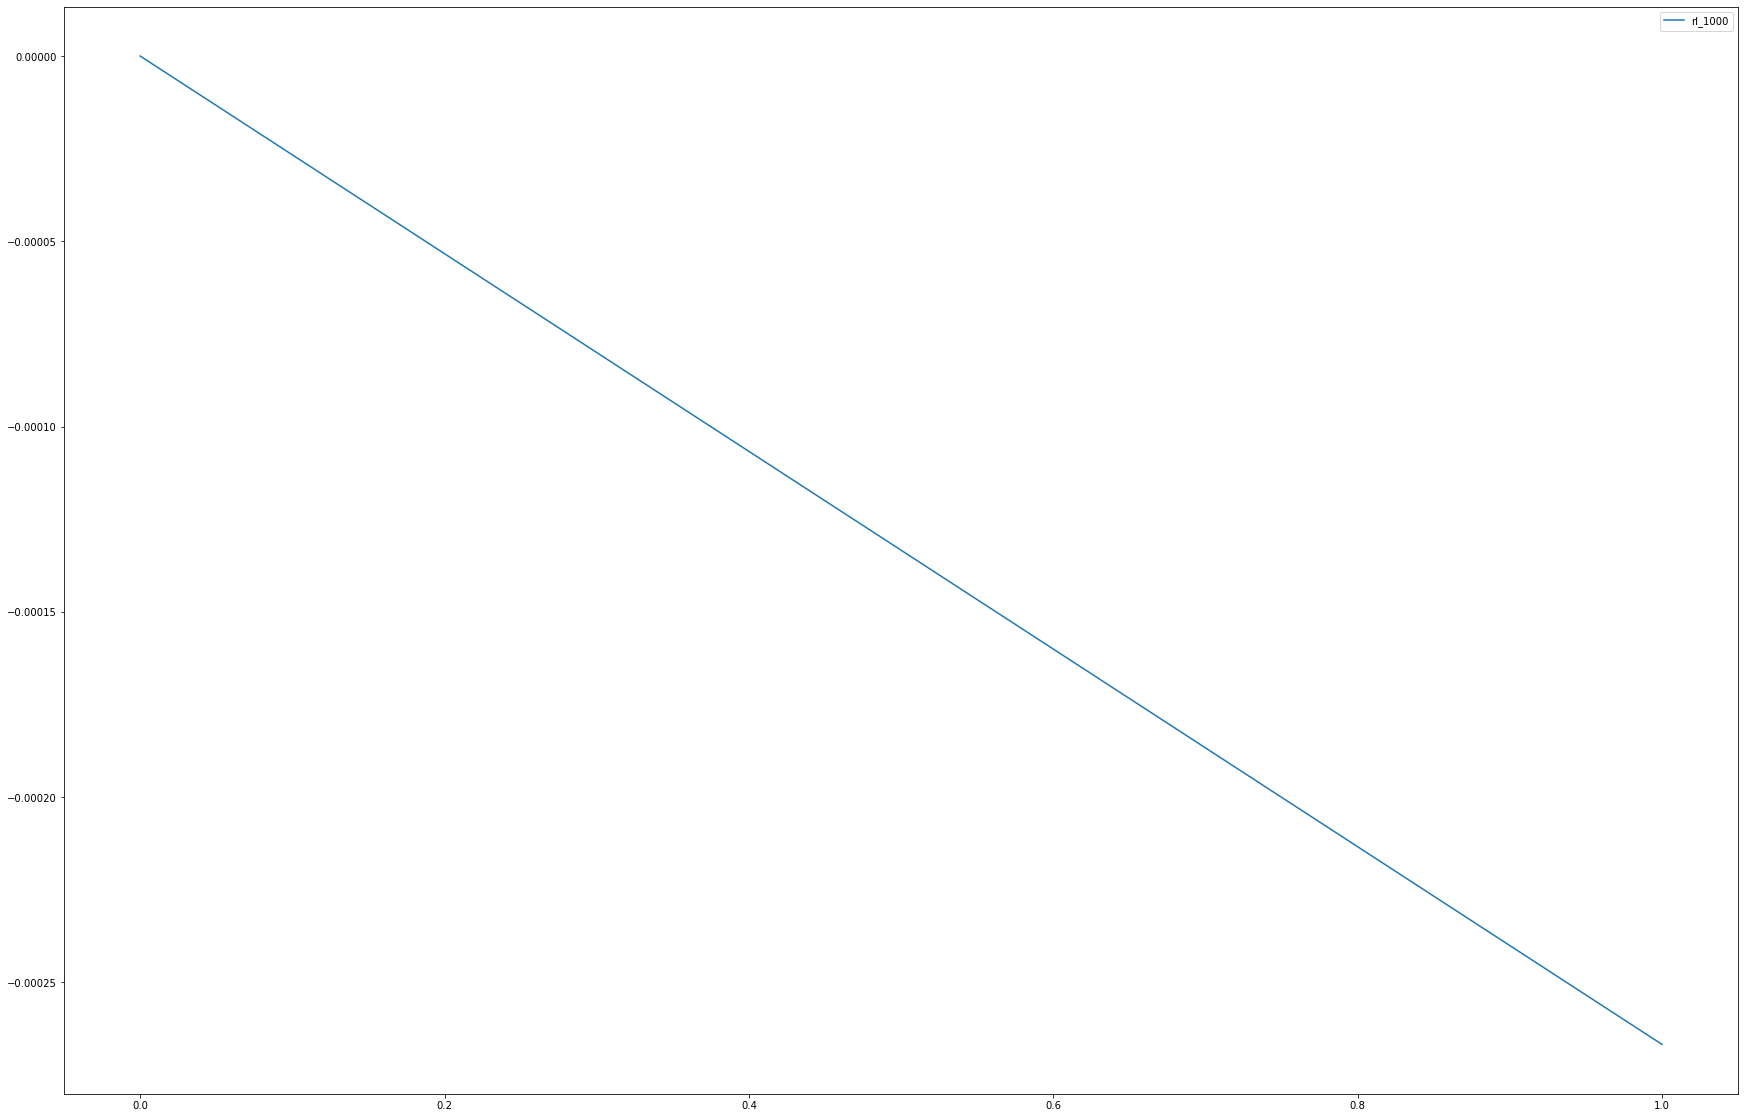

In [14]:
# normalize 
wealth = np.array([agent[group_name]['wealth'] for group_name in group_names])
std_wealth = (wealth - wealth[:, 0].reshape(-1, 1)) / wealth[:, 0].reshape(-1, 1)

plt.figure(figsize=(30, 20))
for i, group_name in enumerate(agent.columns):
    plt.plot(std_wealth[i], label = group_names[i])
plt.legend()

#### Cash

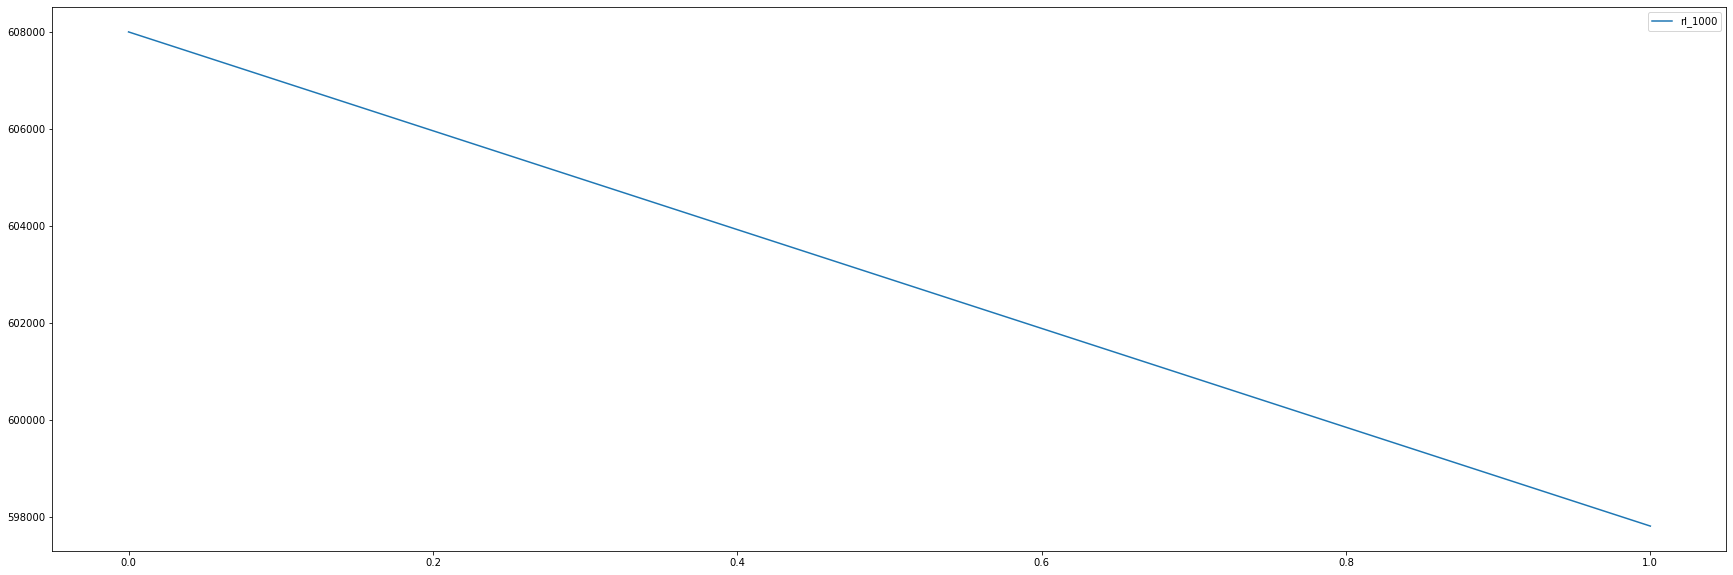

In [15]:
plt.figure(figsize=(30, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['cash'], label = group_names[i])
plt.legend()
plt.show()

#### Security

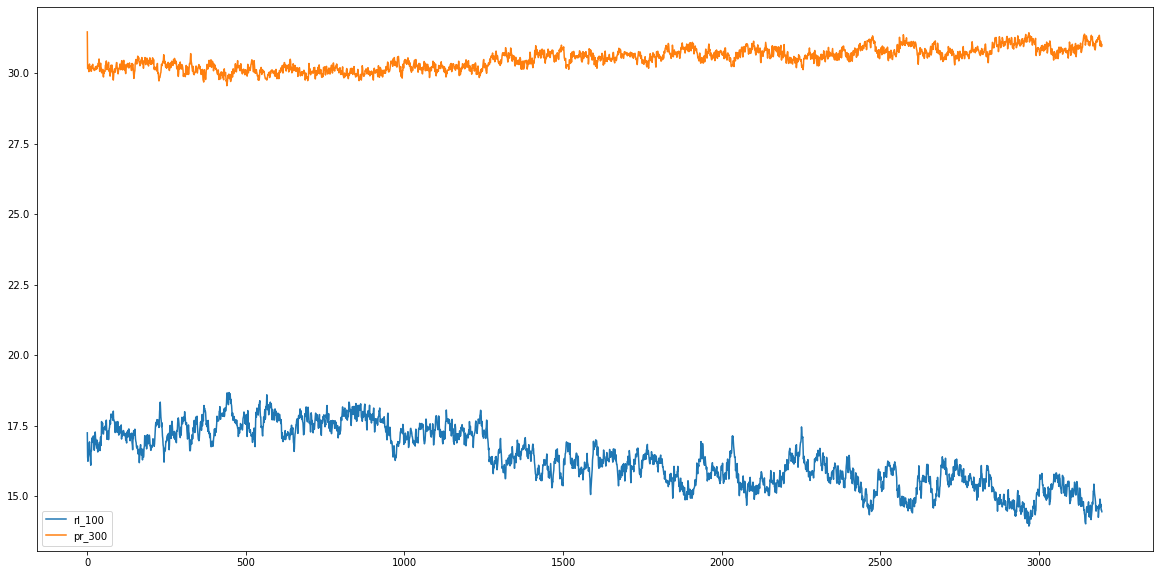

In [21]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['TSMC'], label = group_names[i])
plt.legend()
plt.show()

#### Portfolio

In [23]:
plt.figure(figsize=(20, 10))

close_price = tsmc['close'].to_numpy()
for group_name in group_names:
    security_value = close_price * np.array(agent[group_name]['TSMC']) * 100
    security_propotion = security_value / (np.array(agent[group_name]['cash'])  + security_value)
    plt.plot(security_propotion)
    plt.title(group_name, size = 20)
    plt.show()

NameError: name 'tsmc' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
# baseline_return = pow(1.01, 100) / 2
# for group_name in group_names:
#     plt.figure(figsize=(20, 10))
#     plt.axhline(y = baseline_return)
#     plt.scatter(agent[group_name]['initial_wealth_by_agent'], np.array(agent[group_name]['returns_by_agent']))
#     plt.xlabel('Initial wealth')
#     plt.ylabel('Return')
#     plt.title(f"{group_name}")
#     plt.show()

#### Average cost

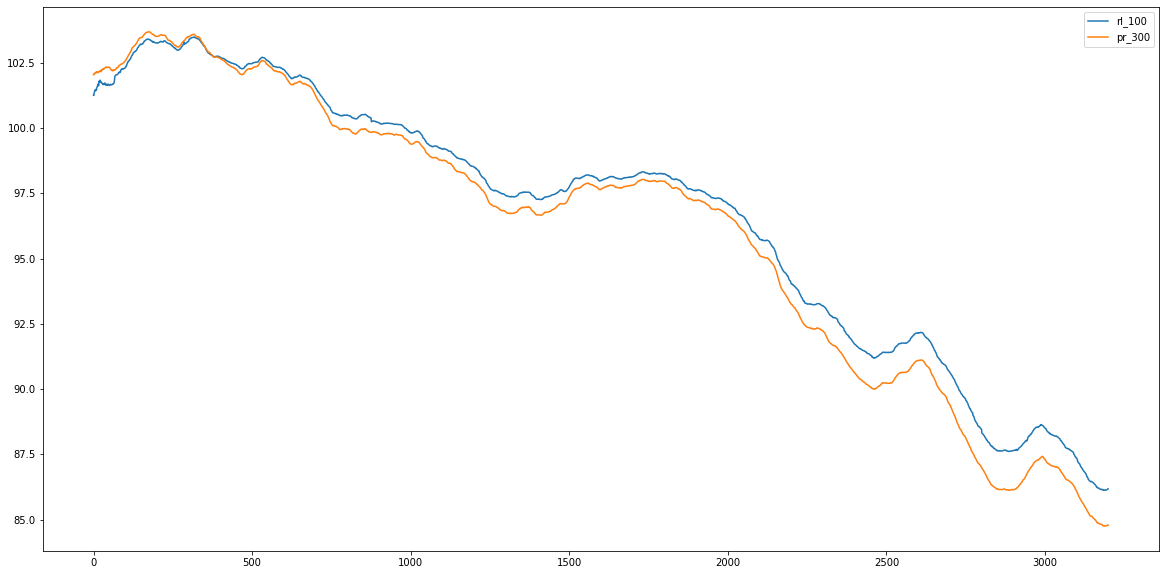

In [24]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['average_cost'], label = group_names[i])
plt.legend()

### Orders

#### Number

#### Each group

In [25]:
from collections import defaultdict

t = list(group_names)
for group_name in group_names:
    if 'zi' in group_name:
        continue
    bids_timestep, bids_price, bids_volume, asks_timestep, asks_price, asks_volume = [], [], [], [], [], []
    bids_price_volume = defaultdict(float)
    asks_price_volume = defaultdict(float)
    
    for i in range(len(agent[group_name]['timestep_bid'])):
        for price, volume in agent[group_name]['timestep_bid'][i].items():
            bids_timestep.append(i)
            bids_price.append(float(price))
            bids_volume.append(volume)
            bids_price_volume[float(price)] += volume
        for price, volume in agent[group_name]['timestep_ask'][i].items():
            asks_timestep.append(i)
            asks_price.append(float(price))
            asks_volume.append(volume)
            asks_price_volume[float(price)] += volume
    
    bids_size = [ 400*(volume - min(bids_volume)) / max(bids_volume) - min(bids_volume) for volume in bids_volume]
    asks_size = [ 400*(volume - min(asks_volume)) / max(asks_volume) - min(asks_volume) for volume in asks_volume]
    plt.plot(tsmc['close'])
    plt.scatter(bids_timestep, bids_price, s = bids_size, c = 'r', marker = 6)
    plt.scatter(asks_timestep, asks_price, s = asks_size, c = 'g', marker = 7)
    plt.title(group_name)
    plt.show()
    plt.bar(list(bids_price_volume.keys()), list(bids_price_volume.values()), color = 'r')
    plt.bar(list(asks_price_volume.keys()), np.array(list(asks_price_volume.values())) * -1, color = 'g')
    plt.show()


NameError: name 'tsmc' is not defined

#### Propotion

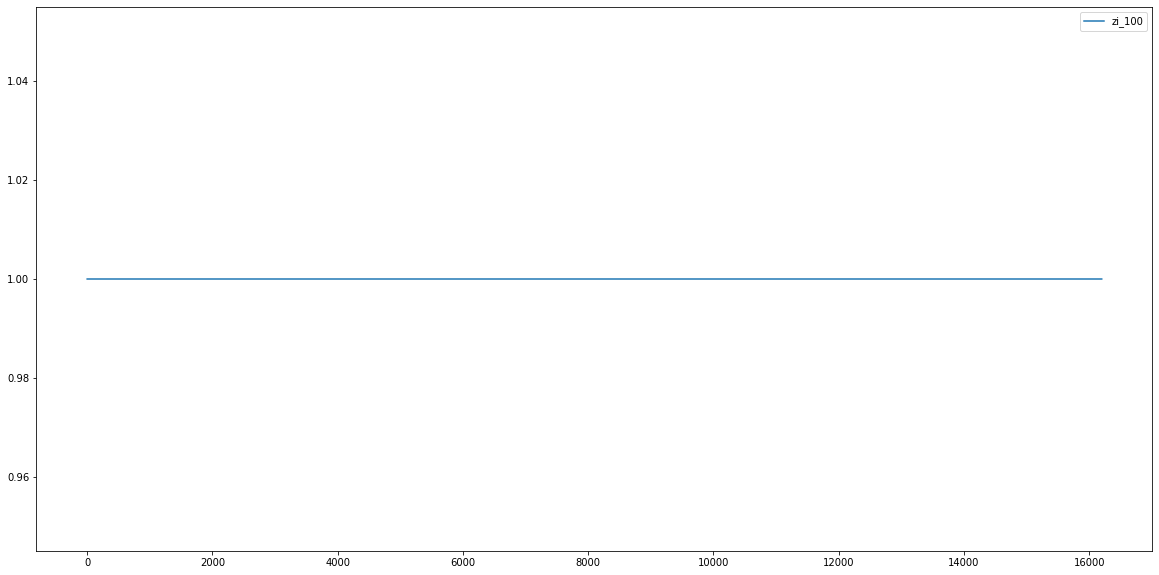

In [90]:
group_bids_volume = [agent.loc['group_bids_volume', group_name] for group_name in group_names]
group_bids_volume = np.array(group_bids_volume).T
group_bids_volume = group_bids_volume / group_bids_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(group_bids_volume[:, i], label = group_names[i])
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
group_asks_volume = [agent.loc['group_asks_volume', group_name] for group_name in group_names]
group_asks_volume = np.array(group_asks_volume).T
group_asks_volume = group_asks_volume / group_asks_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(-1 * group_asks_volume[:, i], label = group_names[i])

# plt.ylim(-0.3, 0.2)
plt.legend()

## RL Agent

In [90]:
import random

record_dir = result_dir / 'train' / train_dirs[0]
security_path = record_dir / "TSMC.json"
agent_path = record_dir / "agent.json"
rl_path = record_dir / 'rl_agent.json'
market = json.loads(security_path.read_text())
agents = json.loads(agent_path.read_text())
rl_states = json.loads(rl_path.read_text())
agent_ids = list(rl_states.keys())

group_name = 'rl_500'
rl_group = agents[group_name]

length = len(market['price'][100:])
timesteps = [i for i in range(length)]

### Relation of reward and performance

In [91]:
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)
state = rl_states[agent_id]
rewards = state['rewards']


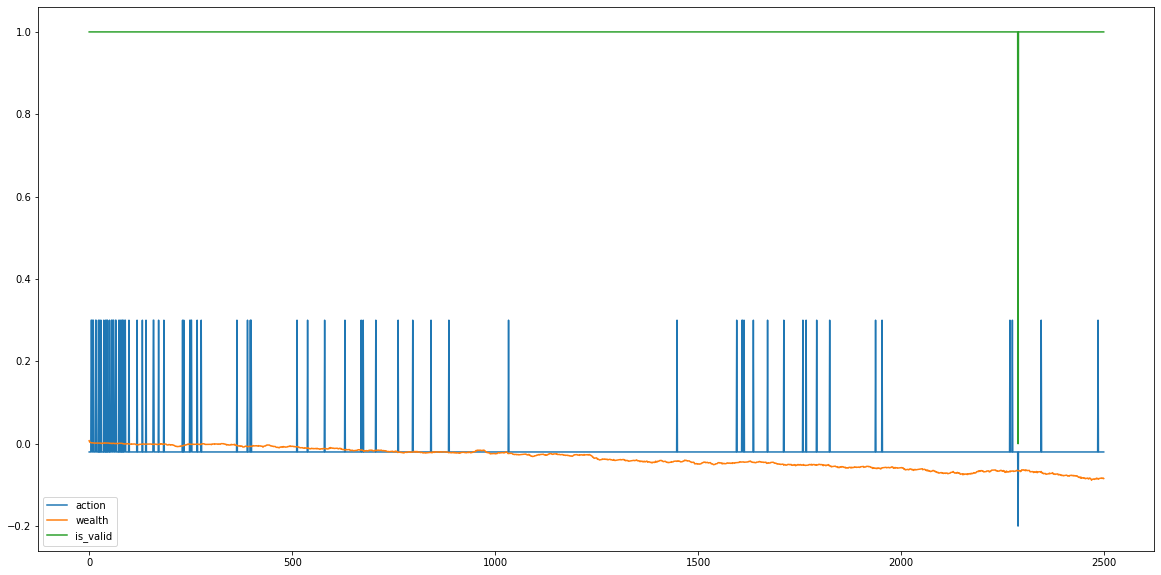

In [92]:
plt.plot(timesteps, rewards, label = ['action', 'wealth', 'is_valid'])
plt.legend()

In [104]:
sim_num = len(train_dirs)
length = len(market['price'][100:])
timesteps = [i for i in range(length)]
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)[0]

total_rewards = []
for i in range(sim_num):
    record_dir = result_dir / 'train' / f'sim_{i}'
#     security_path = record_dir / "TSMC.json"
#     agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
#     market = json.loads(security_path.read_text())
#     agents = json.loads(agent_path.read_text())
    rl_states = json.loads(rl_path.read_text())
    total_rewards.append(rl_states[agent_id]['rewards'])


In [154]:
action_rewards = []
wealth_rewards = []
valid_rewards = []

tr = np.array(total_rewards)
total_reward_by_type = tr.reshape([-1, 3])

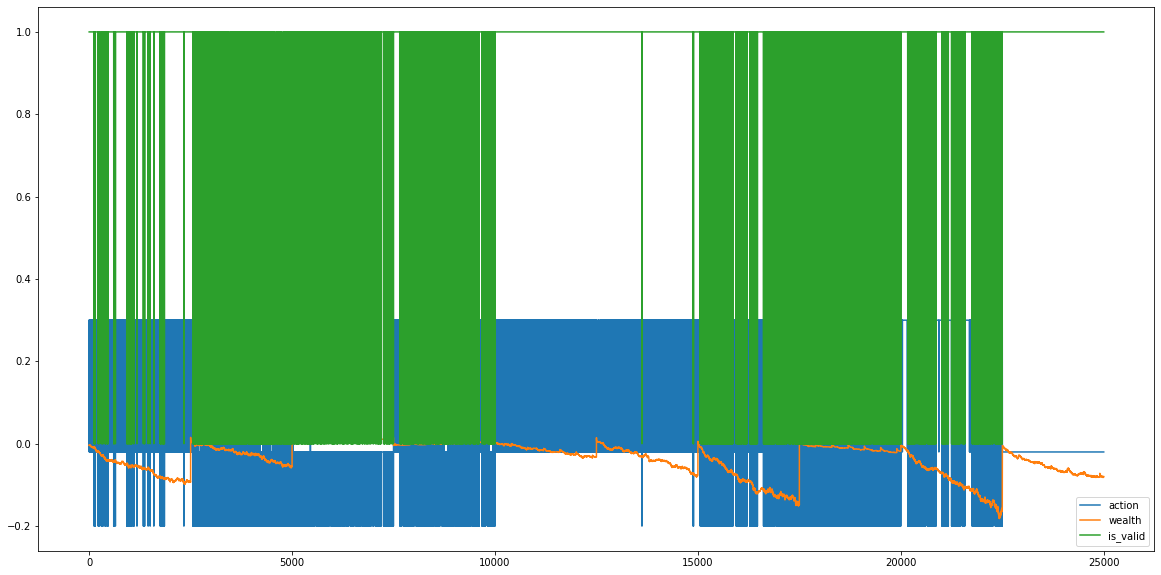

In [156]:
plt.plot(total_reward_by_type, label = ['action', 'wealth', 'is_valid'])
plt.legend()

### Distribution of actions along times from random agent

In [26]:
prices = market['price'][100:]
bids = market['bid_five_price']
asks = market['ask_five_price']
bid_or_asks = []
agent_id = random.sample(agent_ids, 1)[0]
state = rl_states[agent_id]
counters = []
for agent_id, state in rl_states.items():
    bid_or_asks = []
    for i, action in enumerate(state['actions']):
        bid_or_ask = action[0]
        ticks = action[1]
        volume = action[2] + 1
        current_price = prices[i]
        tick_size = 0.1

        if bid_or_ask == 2:
            pass
        elif bid_or_ask == 0:
            # bid
            best_bids = list(bids[i])
            best_bid = current_price if len(best_bids) == 0 else float(best_bids[0])
            price = round(best_bid + (4-ticks) * tick_size, 2)

        elif bid_or_ask == 1:
            # ask
            best_asks = list(asks[i])
            best_ask = current_price if len(best_asks) == 0 else float(best_asks[0])
            price = round(best_ask + (ticks-4) * tick_size, 2)
        bid_or_asks.append(bid_or_ask)


    counter = {0: 0, 1: 0, 2: 0}
    for a in bid_or_asks:
        counter[a] += 1
    counters.append(counter)


In [81]:
hold_times = {i: 0 for i in range(length+1)}
bid_times = {i: 0 for i in range(length+1)}
ask_times = {i: 0 for i in range(length+1)}

for counter in counters:
    bid_times[counter[0]] += 1
    ask_times[counter[1]] += 1
    hold_times[counter[2]] += 1
    

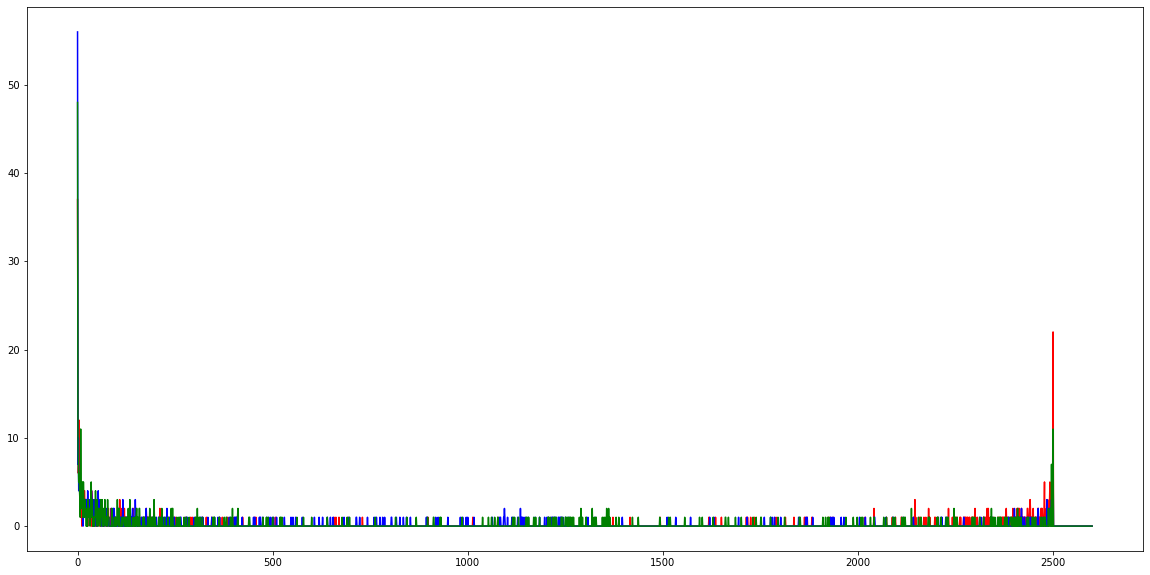

In [68]:
plt.plot(timesteps, list(hold_times.values()), 'r')
plt.plot(timesteps, list(bid_times.values()), 'b')
plt.plot(timesteps, list(ask_times.values()), 'g')

In [43]:
# append data for maintaining the same length
rl_states['states'][-1]['action'] = rl_states['states'][-2]['action']
rl_states['states'][-1]['reward'] = rl_states['states'][-2]['reward']

KeyError: 'states'

In [67]:
timesteps

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
rl_dict = {}
for k, v in rl_states['states'][0].items():
    if type(v) != dict:
        rl_dict[k] = []
    else:
        for key in v.keys():
            rl_dict[key] = []

In [ ]:
for state in rl_states['states']:
    for k, v in state.items():
        if type(v) != dict:
            rl_dict[k].append(v)
        else:
            for key, value in v.items():
                rl_dict[key].append(value)

In [ ]:
rl_df = pd.DataFrame(rl_dict)
rl_df

Reward

In [ ]:
plt.plot(rl_df.wealth / rl_df.wealth[0])
plt.plot(rl_df.wealth_reward)

Action

In [ ]:
'''
1. Discrete 3 - BUY[0], SELL[1], HOLD[2]
2. Discrete 9 - TICK_-4[0], TICK_-3[1], TICK_-2[2], TICK_-1[3], TICK_0[4], TICK_1[5], TICK_2[6], TICK_3[7], TICK_4[8]
3. Discrete 5 - VOLUME_1[0], VOLUME_2[1], VOLUME_3[2], VOLUME_4[3], VOLUME_5[4],
'''
valid_action_rate = rl_df.is_valid.mean()
bid_rate = rl_df.action.apply(lambda x: int(x[0]) == 0).mean()
ask_rate = rl_df.action.apply(lambda x: int(x[1]) == 0).mean()
hold_rate = rl_df.action.apply(lambda x: int(x[2]) == 0).mean()
print(f"Bid rate: {bid_rate}\nAsk rate: {ask_rate}\nHold rate: {hold_rate}\nValid action rate: {valid_action_rate}")

In [ ]:
rl_orders = rl_states['orders']

In [ ]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 200
for order in rl_orders:
    if order['bid_or_ask'] == 'BID':
        if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
        if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])

In [ ]:
x = np.arange(len(tsmc['close']))
plt.figure(figsize=(80, 20))
plt.plot(x[4999: 5101], tsmc['close'][4999:5101])
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()